## Preprocessing

In [2]:
import pandas as pd
import networkx as nx
import localization
import separation
import proximity
import seaborn as sns
import matplotlib.pylab as plt
import numpy as np

In [3]:
disease_gene_data = pd.read_csv('datasets/disease_gene.tsv', sep='\t')
drug_target_data = pd.read_csv('datasets/drug_target.csv')

print("\nBeginning preprocessing:")
print(disease_gene_data.head())
print("------------------------------------------------")
print(drug_target_data.head())
print("Diseases number: ",len(disease_gene_data))
print("Drugs number: ",len(drug_target_data))


Beginning preprocessing:
   geneId geneSymbol    DSI    DPI diseaseId               diseaseName  \
0       1       A1BG  0.700  0.538  C0019209              Hepatomegaly   
1       1       A1BG  0.700  0.538  C0036341             Schizophrenia   
2       2        A2M  0.529  0.769  C0002395       Alzheimer's Disease   
3       2        A2M  0.529  0.769  C0007102  Malignant tumor of colon   
4       2        A2M  0.529  0.769  C0009375         Colonic Neoplasms   

  diseaseType diseaseClass               diseaseSemanticType  score     EI  \
0   phenotype      C23;C06                           Finding   0.30  1.000   
1     disease          F03  Mental or Behavioral Dysfunction   0.30  1.000   
2     disease      C10;F03               Disease or Syndrome   0.50  0.769   
3     disease      C06;C04                Neoplastic Process   0.31  1.000   
4       group      C06;C04                Neoplastic Process   0.30  1.000   

   YearInitial  YearFinal  NofPmids  NofSnps     source  
0 

In [4]:
# Filter disease_gene associations, so that we only focus on those disease types that are not “group” or “phenotype”,
disease_gene_data = disease_gene_data[
    (disease_gene_data['diseaseType'] != 'group') &
    (disease_gene_data['diseaseType'] != 'phenotype')]
print(f"Diseases number after filtering out group and phenotype: {len(disease_gene_data)}")

Diseases number after filtering out group and phenotype: 60478


In [5]:
# Lower disease names and use these names to identify diseases.
# TODO only diseases or also experimental diseases, Familial diseases, etc?
disease_gene_data = disease_gene_data[disease_gene_data.diseaseType == 'disease'][['geneSymbol', 'diseaseName']].drop_duplicates()
disease_gene_data['diseaseName'] = disease_gene_data['diseaseName'].str.lower()
print(f"Diseases number after filtering away duplicates: {len(disease_gene_data)}")

Diseases number after filtering away duplicates: 60478


In [6]:
# Filter disease_gene associations, so that we only focus on those disease that have at least 10 associated genes.
gene_count_per_disease = (disease_gene_data.groupby('diseaseName')
                                             .agg('count')
                                             .sort_values(by='geneSymbol')
                                             .reset_index()
                                             .rename(columns={'geneSymbol':'count_genes'}))

disease_gene_data = disease_gene_data.merge(gene_count_per_disease, 
                         on='diseaseName', 
                         how='inner')

disease_gene_data = disease_gene_data[(disease_gene_data['count_genes'] >= 10)]
print(f"Diseases number after filtering away diseases with less than 10 genes: {len(disease_gene_data)}")

Diseases number after filtering away diseases with less than 10 genes: 44959


In [7]:
# Filter drug targets so that they are related to Humans.
# Use drug names to identify drugs
drug_target_data = drug_target_data[drug_target_data.organism=='Humans'][['Gene_Target','Name']].drop_duplicates()
print(f"Drugs number after filtering away non-human related drugs: {len(drug_target_data)}")

Drugs number after filtering away non-human related drugs: 22751


In [8]:
print("End preprocessing:")
print(disease_gene_data[disease_gene_data['diseaseName'] == 'dermatitis']['geneSymbol'])
disease_gene_data['diseaseName'].drop_duplicates()

End preprocessing:
27729       PARP1
27730        DSG1
27731         EGF
27732        EGFR
27733         FLG
27734       HLA-B
27735    HLA-DQA1
27736         IL4
27737        IL13
27738       ITGB2
27739     PLA2G4A
27740      CXCL12
27741       VCAM1
27742       ZFP36
27743        NOD2
27744     SHARPIN
Name: geneSymbol, dtype: object


0                   schizophrenia
883           alzheimer's disease
984      malignant tumor of colon
1143           presenile dementia
1242            mental depression
                   ...           
56164       coffin-siris syndrome
57851      meckel syndrome type 1
58382      meckel-gruber syndrome
60356      carcinoid, goblet cell
60378              argentaffinoma
Name: diseaseName, Length: 972, dtype: object

## Network medicine

### Disease module

In [9]:
ppi = pd.read_csv('datasets/ppi.csv')
print(f"Number of edges in the PPI: {len(ppi)}")

Number of edges in the PPI: 332749


In [10]:
# drop duplicates
ppi = (ppi[['Symbol_A','Symbol_B']]
       .drop_duplicates()
       .dropna())
print(f"Number of edges in the PPI after removing duplicates: {len(ppi)}")
ppi.head()

Number of edges in the PPI after removing duplicates: 328052


,Symbol_A,Symbol_B
0,PHYHIP,KIF15
1,GPANK1,PNMA1
2,ZRSR2,TTC33
3,NRF1,MAN1B1
4,PI4KA,RGS20


In [11]:
gppi = nx.from_pandas_edgelist(ppi, 'Symbol_A', 'Symbol_B')

# Removing self loops
sl = nx.selfloop_edges(gppi)
gppi.remove_edges_from(sl)
print(f"Number of edges in the PPI after removing self loops: {len(gppi.edges)}")

Number of edges in the PPI after removing self loops: 322289


In [12]:
def get_disease_module_info(dis_name, gda, ppi):
    
    d = gda[gda.diseaseName == dis_name]
    genes = set(d.geneSymbol)
    genes_in_ppi = [n for n in gppi.nodes if n in genes]
    genes_in_lcc = localization.get_lcc(ppi, genes_in_ppi)
    
    print('Number of disease genes: ',len(genes))
    print('Number of disease genes in the PPI: ',len(genes_in_ppi))
    print('Number of disease genes in the LCC: ',len(genes_in_lcc))
    
    disease_module = ppi.subgraph(genes_in_lcc)

    # Visualization of the disease module
    plt.figure(figsize=(10, 10))
    nx.draw(disease_module, with_labels=True)
    plt.title("Disease Module Visualization")
    plt.show()
    
    return genes, genes_in_ppi, genes_in_lcc, disease_module

Number of disease genes:  16
Number of disease genes in the PPI:  16
Number of disease genes in the LCC:  7


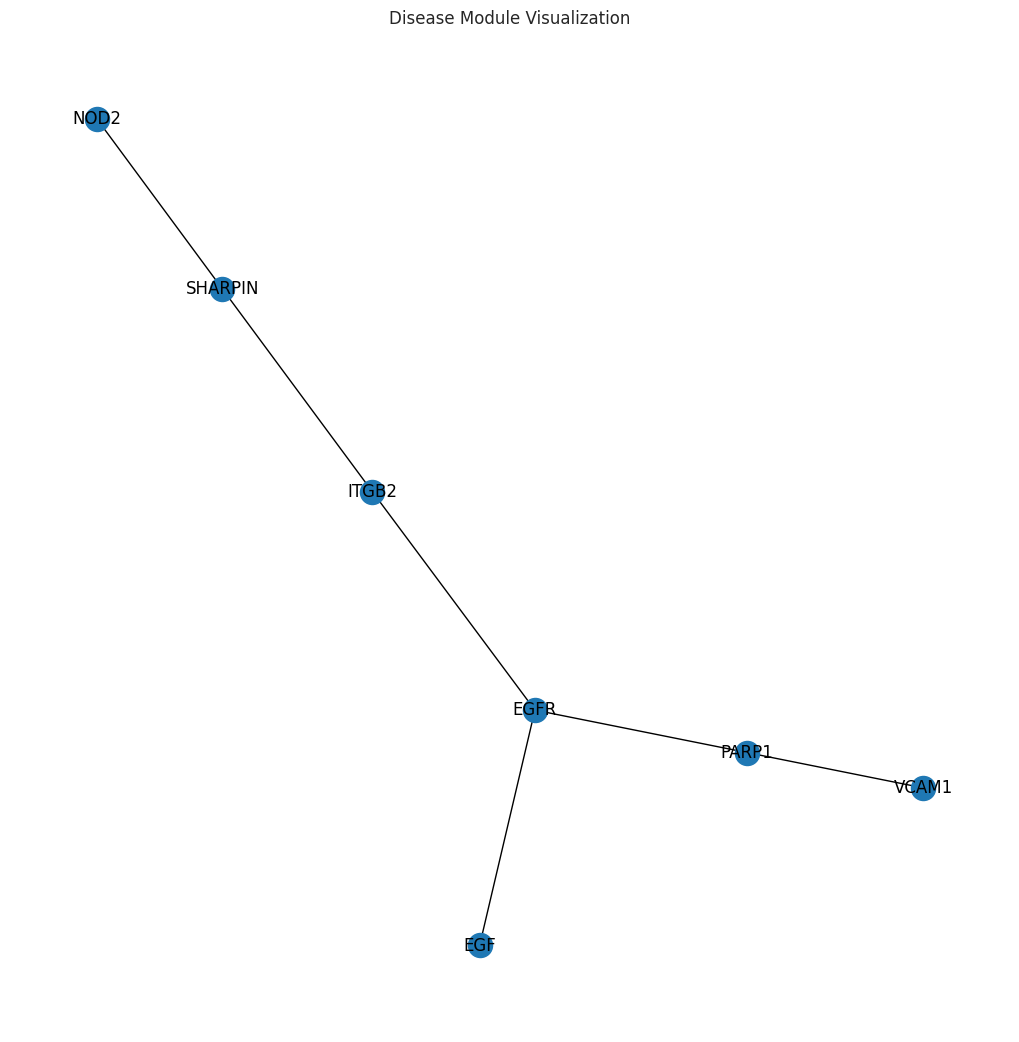

In [13]:
dermatitis = get_disease_module_info('dermatitis', disease_gene_data, gppi)
dermatitis_module = dermatitis[3]


Number of disease genes:  883
Number of disease genes in the PPI:  846
Number of disease genes in the LCC:  683


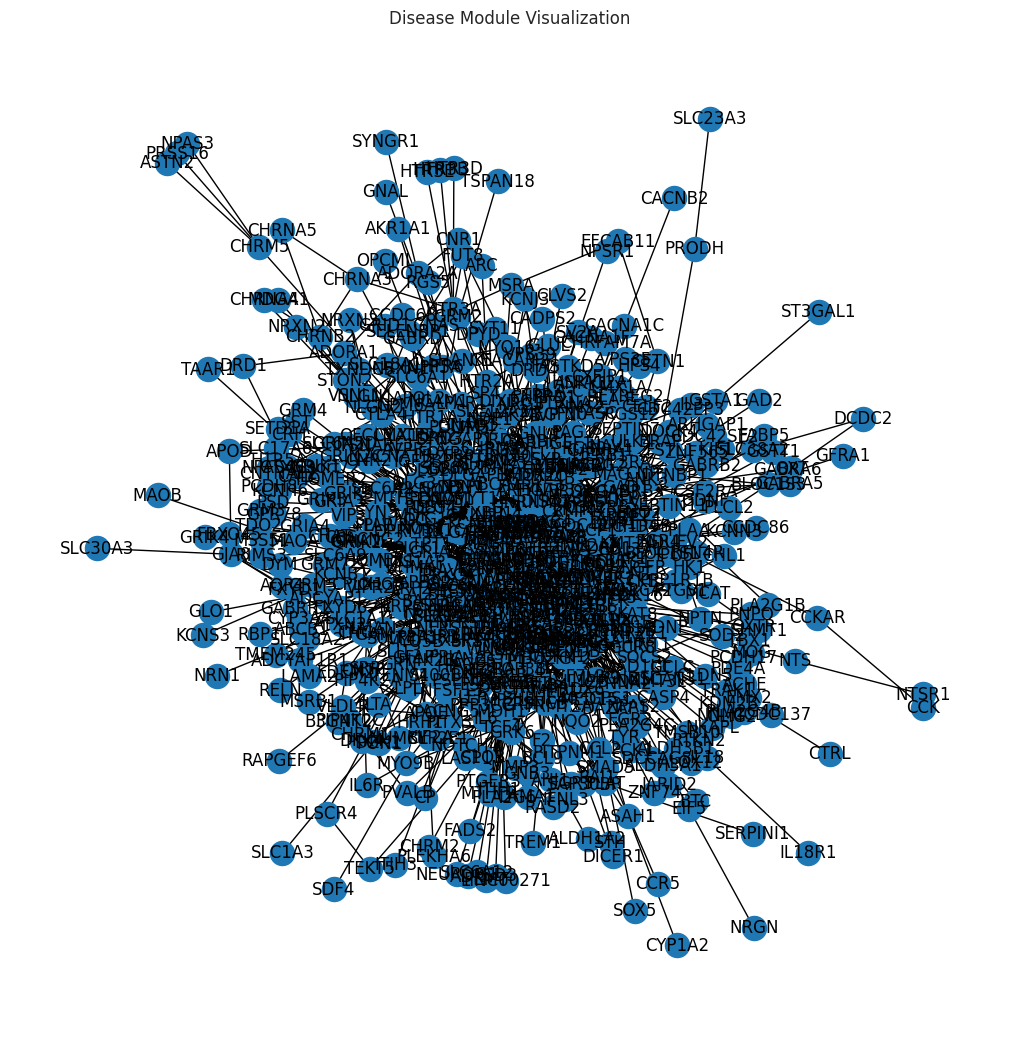

In [14]:
random_disease_name = "schizophrenia"
random_disease = get_disease_module_info(random_disease_name, disease_gene_data, gppi)
random_module = random_disease[3]

In [15]:
# compare degrees of disease modules
def get_degrees_module(module):
    return np.mean([d for n, d in module.degree])

In [16]:
print(f"Average degree of the disease module of dermatitis: {get_degrees_module(dermatitis[3])}")
print(f"Average degree of the disease module of {random_disease_name}: {get_degrees_module(random_disease[3])}")

Average degree of the disease module of dermatitis: 1.7142857142857142
Average degree of the disease module of schizophrenia: 7.487554904831625


In [17]:
dermatitis_density = nx.density(dermatitis_module)
random_density = nx.density(random_module)

print("Density of dermatitis module:", dermatitis_density)
print("Density of random module:", random_density)

Density of dermatitis module: 0.2857142857142857
Density of random module: 0.01097881950855077


In [18]:
dermatitis_clustering = nx.average_clustering(dermatitis_module)
random_clustering = nx.average_clustering(random_module)

print("Average clustering coefficient of dermatitis module:", dermatitis_clustering)
print("Average clustering coefficient of random module:", random_clustering)

Average clustering coefficient of dermatitis module: 0.0
Average clustering coefficient of random module: 0.15072017890624828


In [19]:
dermatitis_path_length = nx.average_shortest_path_length(dermatitis_module)
random_path_length = nx.average_shortest_path_length(random_module)

print("Average shortest path length of dermatitis module:",dermatitis_path_length)
print("Average shortest path length of random module:", random_path_length)

Average shortest path length of dermatitis module: 2.380952380952381
Average shortest path length of random module: 3.377848288772579


### Disease separation

Number of disease genes:  57
Number of disease genes in the PPI:  57
Number of disease genes in the LCC:  30


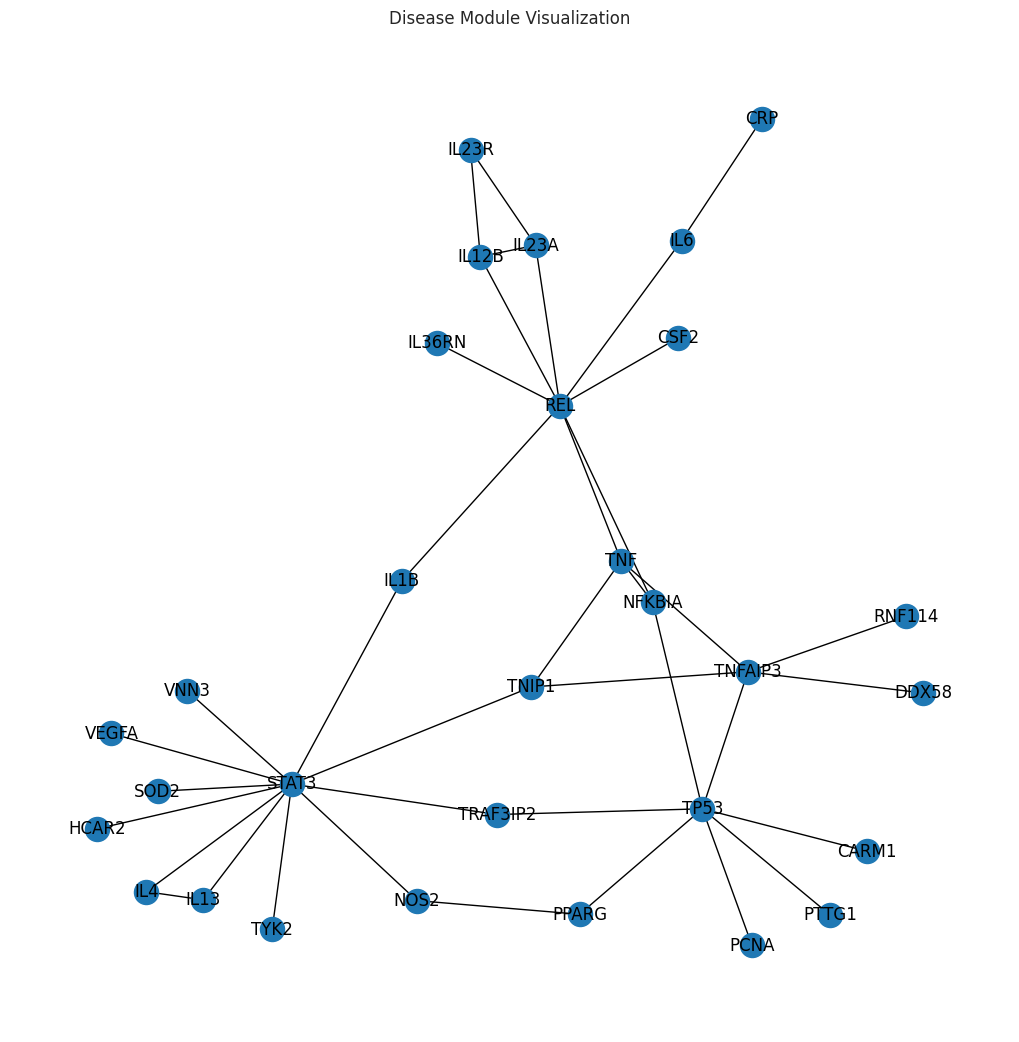

separation_dermatitis_psoriasis :  1.6216216216216217


In [20]:
# Work on the molecular overlap of the disease you are studying with other diseases. Chose two particular diseases: one that apparently might overlap with your disease and one that apparently might be very distant to your disease. Compute the separation in the interactome of the two disease modules. Connect this question to question 3.2. Discuss the possible implications of the separation between the two diseases. 

# Let's compare Dermatitis and Psoriasis

psoriasis = get_disease_module_info('psoriasis', disease_gene_data, gppi)
separation_dermatitis_psoriasis = separation.get_separation(gppi, psoriasis[2], dermatitis[2])
print("separation_dermatitis_psoriasis : ",separation_dermatitis_psoriasis)

Number of disease genes:  883
Number of disease genes in the PPI:  846
Number of disease genes in the LCC:  683


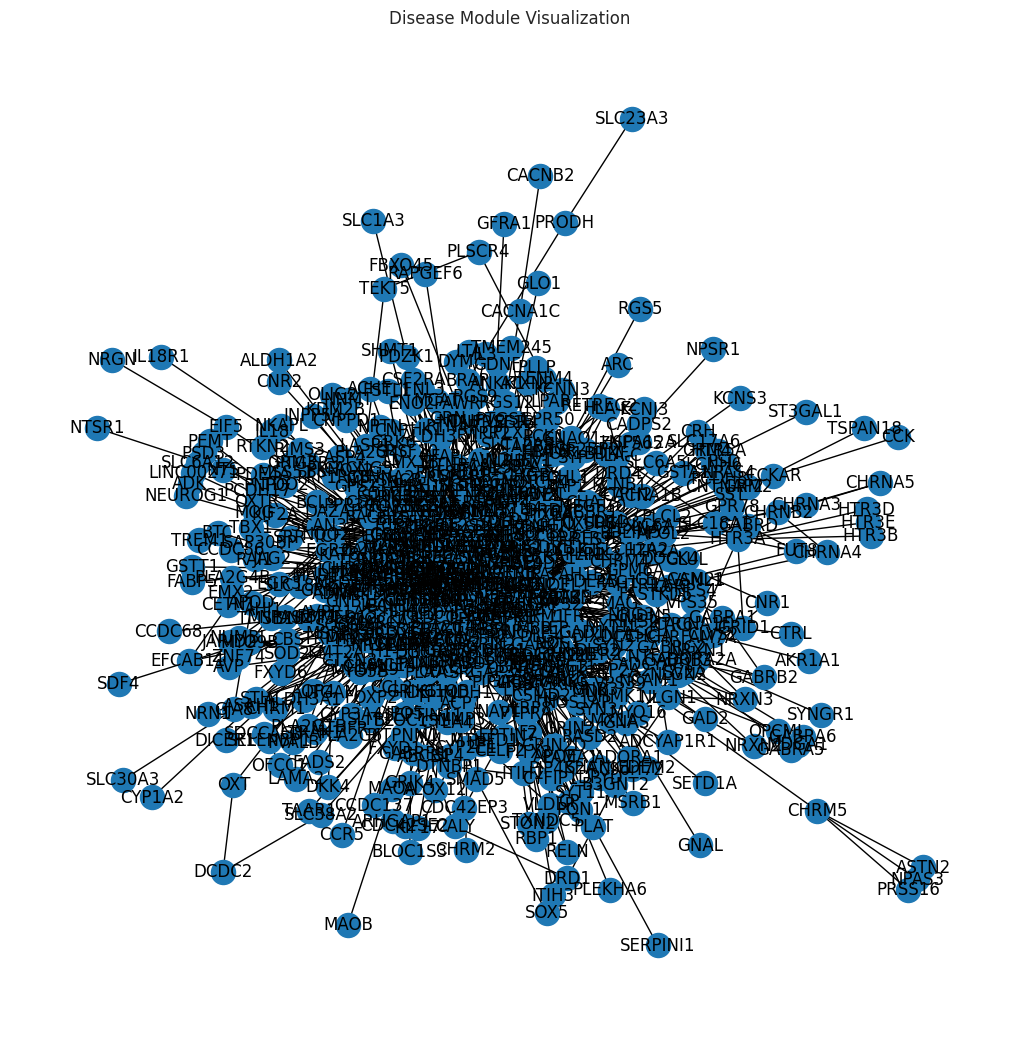

separation_dermatitis_schizophrenia :  1.8753623188405797


In [21]:
# Let's now compare Dermatitis and Schizophrenia
# TODO is schizophrenia a good example? It seems to have way more disease genes than dermatitis and psoriasis.

schizophrenia = get_disease_module_info('schizophrenia', disease_gene_data, gppi)
separation_dermatitis_schizophrenia = separation.get_separation(gppi, schizophrenia[2], dermatitis[2])
print("separation_dermatitis_schizophrenia : ",separation_dermatitis_schizophrenia)

Number of disease genes:  25
Number of disease genes in the PPI:  25
Number of disease genes in the LCC:  14


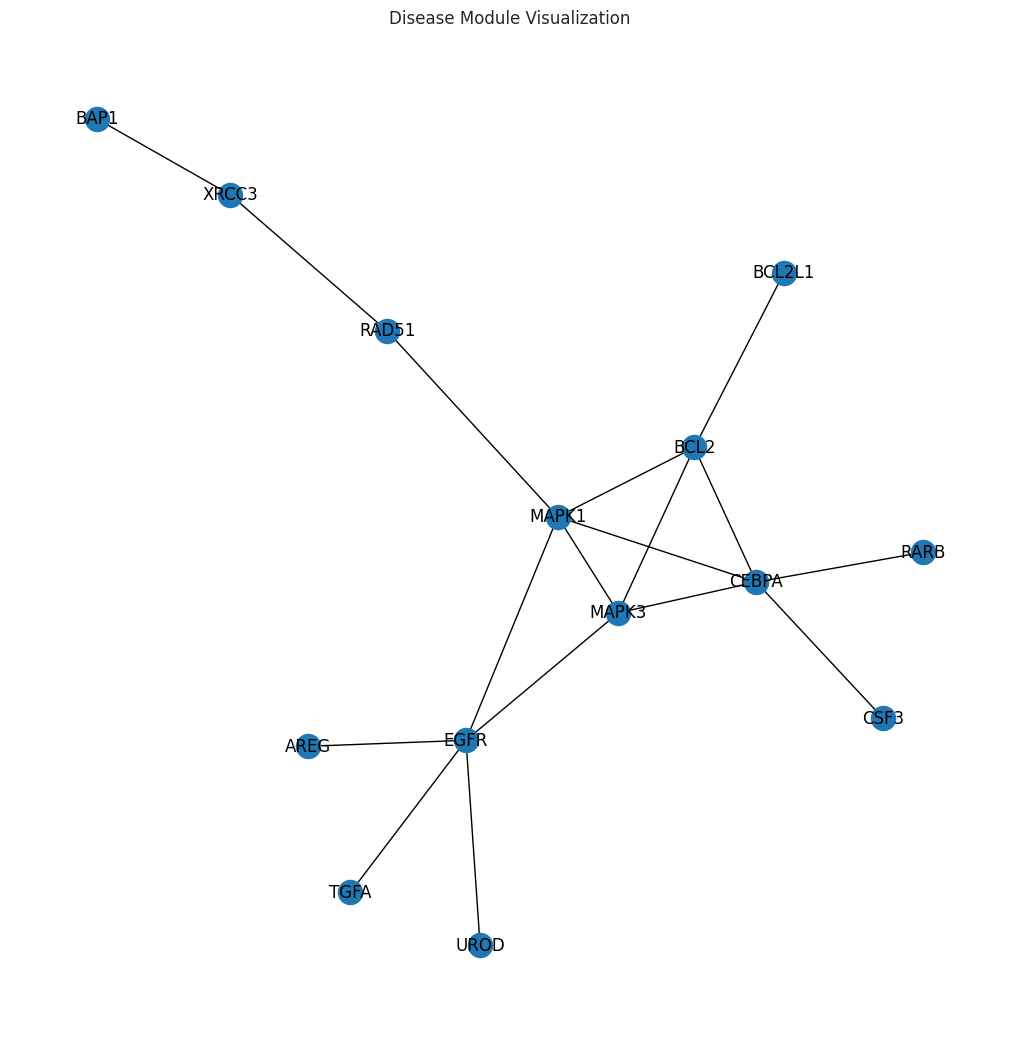

dermatititis and Cancer of Neck : 1.2857142857142858


In [22]:
test_name = "Cancer of Neck"
test_disease = get_disease_module_info(test_name.lower(), disease_gene_data, gppi)
separation_dermatitis_test_disease = separation.get_separation(gppi, test_disease[2], dermatitis[2])
print(f"dermatititis and {test_name} : {separation_dermatitis_test_disease}")

### Disease - drug proximity

In [23]:
def plot_proximity(G, genes, targets, sim):
    
    prox_dict = proximity.get_proximity(G, genes, targets, sim)
    
    prox_obs = prox_dict['proximity']
    random_prox = prox_dict['proximity_list']

    print('Proximity observed: ',prox_obs)
    print('\nMean: ',prox_dict['mean'])
    print('Std: ',prox_dict['std'])
    print('z-score: ',prox_dict['z_score'])
    print('p-value: ',prox_dict['p_value'])


    fig, axs = plt.subplots()
    sns.histplot(data=random_prox,
                 bins=10)
    plt.axvline(prox_obs, color='r')
    plt.xlabel('Proximity value')
    plt.ylabel('Count iterations')
    plt.tight_layout()
    plt.show()

In [24]:
selected_drugs = drug_target_data[drug_target_data.Gene_Target.isin(dermatitis[2])][['Name', 'Gene_Target']].drop_duplicates()
print("Selected drugs targeting genes involved in Atopic Dermatitis")
print(selected_drugs)
drug_target_data = selected_drugs.head(5)
print("---------------------------------------------------------------------------------")
print("5 first drugs targeting genes involved in Atopic Dermatitis", drug_target_data)

Selected drugs targeting genes involved in Atopic Dermatitis
                                                    Name Gene_Target
1                                              Cetuximab        EGFR
2140                                        Theophylline       PARP1
2190                                           Lidocaine        EGFR
2462                                           Gefitinib        EGFR
2835                                          Sucralfate         EGF
4115                                           Erlotinib        EGFR
6751                                             Ethanol       VCAM1
8576                                          Carvedilol       VCAM1
9567                                           Lapatinib        EGFR
9629                                         Panitumumab        EGFR
10634                                               Zinc       PARP1
12291            Carba-nicotinamide-adenine-dinucleotide       PARP1
12570                                     

Cetuximab - Targets: ['EGFR']
Proximity observed:  1.2857142857142858

Mean:  1.619857142857143
Std:  0.11176496840810765
z-score:  -2.9896922255884424
p-value:  0.002792586723795454


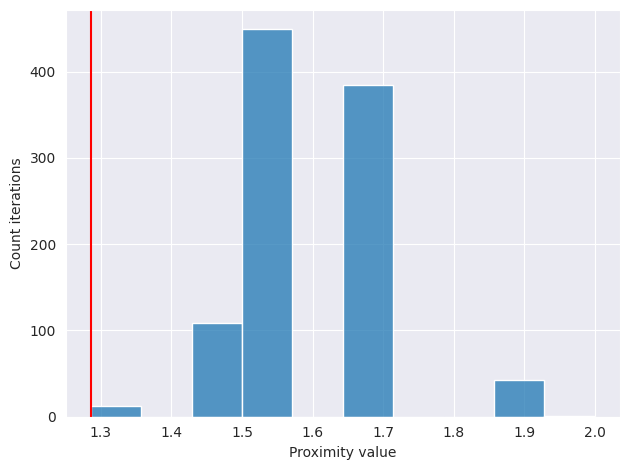

Theophylline - Targets: ['PARP1']
Proximity observed:  1.4285714285714286

Mean:  1.6192857142857142
Std:  0.16167332898818668
z-score:  -1.179627381385961
p-value:  0.23814844769267585


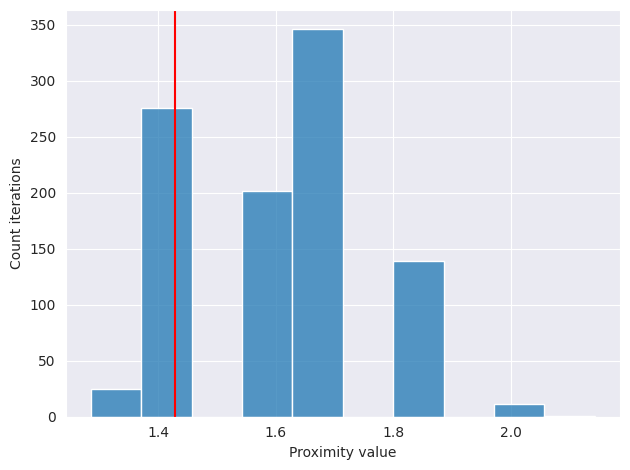

Lidocaine - Targets: ['EGFR']
Proximity observed:  1.2857142857142858

Mean:  1.6192857142857147
Std:  0.1101737959141031
z-score:  -3.0276839043605026
p-value:  0.0024643571366445016


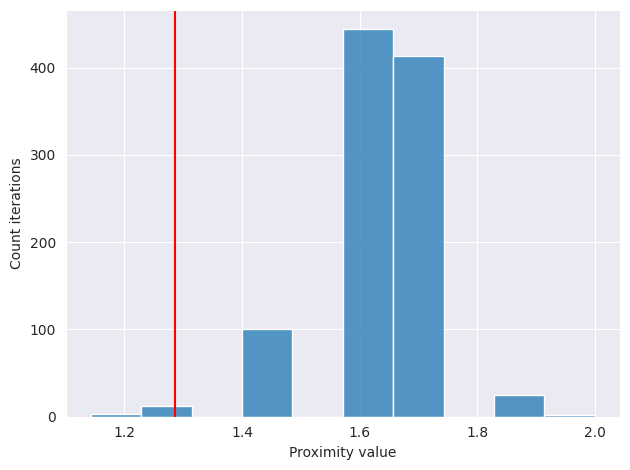

Gefitinib - Targets: ['EGFR']
Proximity observed:  1.2857142857142858

Mean:  1.6132857142857144
Std:  0.10796361821068637
z-score:  -3.034090872465825
p-value:  0.0024126174607883577


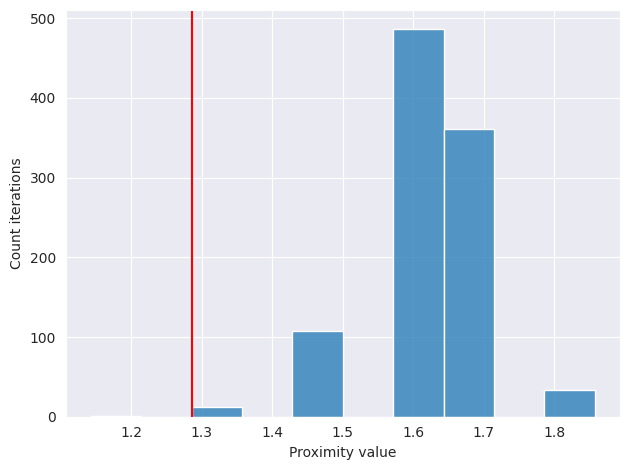

Sucralfate - Targets: ['EGF']
Proximity observed:  1.7142857142857142

Mean:  2.222285714285714
Std:  0.16180512340214592
z-score:  -3.1395792006995404
p-value:  0.001691906729287762


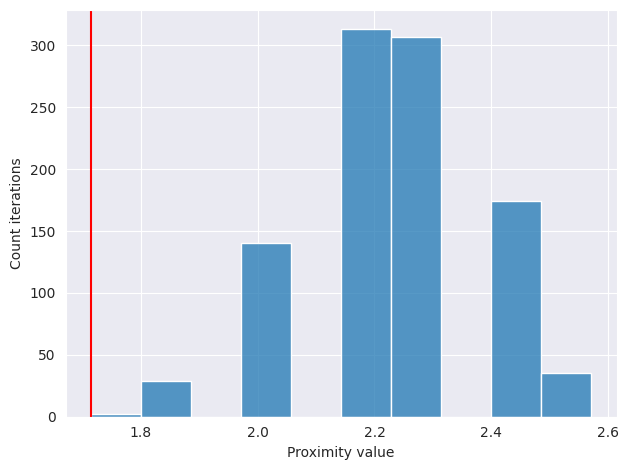

In [25]:
for drug_name in drug_target_data['Name']:
    le_t = drug_target_data[drug_target_data['Name'] == drug_name]['Gene_Target'].unique()

    print(f"{drug_name} - Targets: {le_t}")
    plot_proximity(gppi, 
               set(dermatitis[2]),
               set(le_t), 
               1000)

## 3. Disease networks

### 3.1. General network metrics

In [44]:
# Creating a new graph
proj_disease_network = nx.Graph()

# Dictionary to store groups and their associated names
group_dict = {}

# Populating the dictionary
for name, group in disease_gene_data[['diseaseName', 'geneSymbol']].values:
    if group in group_dict:
        group_dict[group].add(name)
    else:
        group_dict[group] = {name}

# Adding edges based on groups
for group, names in group_dict.items():
    for name in names:
        # Add edges between this name and all other names in the same group
        for other_name in names:
            if name != other_name:
                proj_disease_network.add_edge(name, other_name)

In [45]:
# number of connected components
nx.number_connected_components(proj_disease_network)

1

In [46]:
nx.diameter(proj_disease_network)

3

In [48]:
degrees = [(n, proj_disease_network.degree(n)) for n in proj_disease_network.nodes()]

degrees_df = pd.DataFrame(degrees, columns=['node', 'degree'])
degrees_df.head(50)

,nodes,degree
0,atherosclerosis,537
1,hyperlipoproteinemia type iib,120
2,hypercholesterolemia,240
3,schizophrenia,868
4,colorectal carcinoma,857
5,"hypercholesterolemia, familial",126
6,hyperlipoproteinemia type iia,125
7,"kidney failure, chronic",454
8,presenile dementia,657
9,memory disorders,441


In [62]:
# count the number of nodes with a given degree and sort by degree
dd = degrees_df.groupby('degree').count().reset_index().rename(columns={'node':'nodes'})
dd.head(50)

,degree,nodes
0,10,3
1,11,1
2,12,2
3,14,5
4,15,2
5,16,2
6,17,6
7,18,4
8,19,2
9,20,1


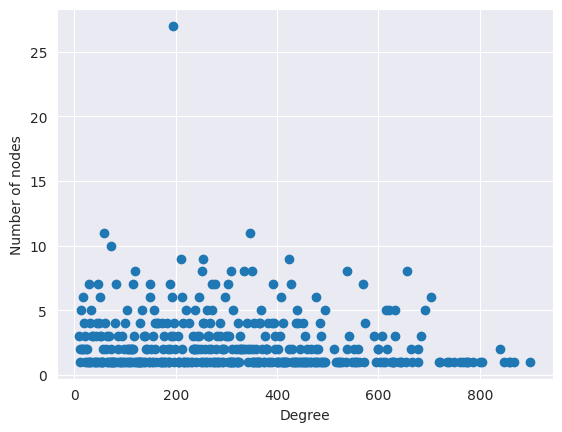

In [60]:
# make a scatter plot of the degree distribution
plt.scatter(dd['degree'], dd['nodes'])
plt.xlabel('Degree')
plt.ylabel('Number of nodes')

plt.show()

In [63]:
# find the hubs
degrees_df.sort_values(by='degree', ascending=False).head(10)

,nodes,degree
18,malignant neoplasm of breast,900
3,schizophrenia,868
32,malignant neoplasm of prostate,859
4,colorectal carcinoma,857
22,breast carcinoma,847
12,"mammary carcinoma, human",840
36,"mammary neoplasms, human",840
56,bipolar disorder,805
50,liver carcinoma,800
77,depressive disorder,786


In [64]:
# plot shortest path distribution
# TODO
shortest_paths = nx.shortest_path_length(proj_disease_network)
shortest_paths

<generator object all_pairs_shortest_path_length at 0x7f42ab66e890>

In [ ]:
# Drawing the optimized graph
nx.draw(proj_disease_network, with_labels=True)
plt.show()

### 3.2. Specific disease in the network